In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
x = np.linspace(-4, 4, 201).reshape(-1,1)
x = np.concatenate([x, x], 1)
y =[]
for i in range(len(x)):
    y.append( [np.cos(x[i,0])+0.1*x[i,1]**2, np.sin(x[i,1])+x[i,0]**3]   )
y = np.array(y)

idx = np.random.permutation(np.arange(len(x)))
test_ratio=0.2
train_x = x[idx[int(test_ratio*len(x)):]]
train_y = y[idx[int(test_ratio*len(x)):]]
test_x  = x[idx[:int(test_ratio*len(x))]]      
test_y  = y[idx[:int(test_ratio*len(x))]]      
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(161, 2) (161, 2)
(40, 2) (40, 2)


In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset

import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



class SVGP:
    def __init__(self, inputs, targets, inducing_num=128):

        self.inputs  = inputs
        self.targets = targets
        
        self.pca = PCA(whiten=True)
        self.sc  = StandardScaler()
        self.pca.fit(inputs)
        self.sc.fit(targets)
        self.inputs  = self.pca.transform(inputs)
        self.targets = self.sc.transform(targets)
        
        inducing_points = torch.from_numpy(self.inputs.astype(np.float32))[:inducing_num, :]
        self.model = []
        self.likelihood = []
        for i in range(targets.shape[1]):
            self.model.append(GPModel(inducing_points))
            self.likelihood.append(gpytorch.likelihoods.GaussianLikelihood())
        

    def train(self, holdout_ratio=0.1, early_stop=20):
        idx = np.random.permutation(np.arange(len(self.inputs)))
        inputs_t = self.inputs[idx[int(holdout_ratio*len(self.inputs)):]]
        inputs_v = self.inputs[idx[:int(holdout_ratio*len(self.inputs))]]        
        targets_t = self.targets[idx[int(holdout_ratio*len(self.inputs)):]]
        targets_v = self.targets[idx[:int(holdout_ratio*len(self.inputs))]]
        
        dataset_t = TensorDataset(torch.from_numpy(inputs_t.astype(np.float32)), torch.from_numpy(targets_t.astype(np.float32)))
        loader_t  = DataLoader(dataset_t, batch_size=32, shuffle=True, drop_last=True)

        dataset_v = TensorDataset(torch.from_numpy(inputs_v.astype(np.float32)), torch.from_numpy(targets_v.astype(np.float32)))
        loader_v  = DataLoader(dataset_v, batch_size=32, shuffle=True, drop_last=False)
        
        for i in range(targets_t.shape[1]):
            self.model[i].train()
            self.likelihood[i].train()        

        params_ = []
        for i in range(targets_t.shape[1]):
            params_.append({"params":self.model[i].parameters()})
            params_.append({"params":self.likelihood[i].parameters()})
            
        optimizer = torch.optim.Adam(params_, lr = 0.01)

        mll=[]
        for i in range(targets_t.shape[1]):
            mll.append(gpytorch.mlls.VariationalELBO(self.likelihood[i], self.model[i], num_data=inputs_t.shape[0]))
                
        cnt=0
        best_valid_loss=1e10
        for i in range(10000):    
            train_loss=[]
            for x_t,y_t in loader_t:
                optimizer.zero_grad()
                loss = 0.
                for i2 in range(targets_t.shape[1]):
                    loss += -mll[i2](self.model[i2](x_t), y_t[:,i2])
                loss.backward() 
                optimizer.step()
                train_loss.append(loss.item())

            valid_loss=[]
            for x_v,y_v in loader_t:
                with torch.no_grad():
                    loss = 0.
                    for i2 in range(targets_t.shape[1]):
                        loss += -mll[i2](self.model[i2](x_v), y_v[:,i2])
                    valid_loss.append(loss.item())
        
            train_loss=sum(train_loss)/len(train_loss)
            valid_loss=sum(valid_loss)/len(valid_loss)

            if best_valid_loss>valid_loss:
                best_valid_loss=valid_loss
                cnt=0
            else:
                cnt+=1

            if i%10==0:
                print(i,cnt,best_valid_loss,valid_loss)
                
            if cnt>=early_stop:
                break
        for i in range(targets_t.shape[1]):                
            self.model[i].eval()
            self.likelihood[i].eval()                 

    def train2(self, convergence_step=20):
        inputs_t = self.inputs
        targets_t = self.targets
        
        dataset_t = TensorDataset(torch.from_numpy(inputs_t.astype(np.float32)), torch.from_numpy(targets_t.astype(np.float32)))
        loader_t  = DataLoader(dataset_t, batch_size=32, shuffle=True, drop_last=True)
        
        for i in range(targets_t.shape[1]):
            self.model[i].train()
            self.likelihood[i].train()        

        params_ = []
        for i in range(targets_t.shape[1]):
            params_.append({"params":self.model[i].parameters()})
            params_.append({"params":self.likelihood[i].parameters()})
            
        optimizer = torch.optim.Adam(params_, lr = 0.01)

        mll=[]
        for i in range(targets_t.shape[1]):
            mll.append(gpytorch.mlls.VariationalELBO(self.likelihood[i], self.model[i], num_data=inputs_t.shape[0]))
                
        cnt=0
        best_train_loss=1e10
        for i in range(10000):    
            train_loss=[]
            for x_t,y_t in loader_t:
                optimizer.zero_grad()
                loss = 0.
                for i2 in range(targets_t.shape[1]):
                    loss += -mll[i2](self.model[i2](x_t), y_t[:,i2])
                loss.backward() 
                optimizer.step()
                train_loss.append(loss.item())
        
            train_loss=sum(train_loss)/len(train_loss)

            if best_train_loss>train_loss:
                best_train_loss=train_loss
                cnt=0
            else:
                cnt+=1

            if i%10==0:
                print(i,cnt,best_train_loss,train_loss)
                
            if cnt>=convergence_step:
                break
        for i in range(targets_t.shape[1]):                
            self.model[i].eval()
            self.likelihood[i].eval()                 
            
            
    def predict(self, inputs):
        inputs_pca = self.pca.transform(inputs)
        with torch.no_grad():
            y_sc = []
            for i in range(self.targets.shape[1]):
                targets_sc = self.model[i](torch.from_numpy(inputs_pca.astype(np.float32)))
                targets_sc = self.likelihood[i](targets_sc).to_data_independent_dist().sample()
                y_sc.append(targets_sc.cpu().numpy())
        y_sc = np.array(y_sc).T
        return self.sc.inverse_transform(y_sc)

    def predict_(self, inputs):
        inputs_pca = self.pca.transform(inputs)
        with torch.no_grad():
            y_sc = []
            for i in range(self.targets.shape[1]):
                targets_sc = self.model[i](torch.from_numpy(inputs_pca.astype(np.float32))).mean
                y_sc.append(targets_sc.cpu().numpy())
            y_sc = np.array(y_sc).T
        return self.sc.inverse_transform(y_sc)

In [4]:
reg = SVGP(x,y)

In [5]:
reg.train2()

0 0 3.5384334325790405 3.5384334325790405
10 0 2.1462743679682412 2.1462743679682412
20 0 1.6882278124491374 1.6882278124491374
30 0 1.2828332980473836 1.2828332980473836
40 0 0.8902288873990377 0.8902288873990377
50 0 0.5459073583285013 0.5459073583285013
60 2 0.2949242517352104 0.3145771697163582
70 0 0.13168732325236002 0.13168732325236002
80 3 -0.10307709872722626 -0.0448838472366333
90 1 -0.21298226217428842 -0.1950955664118131
100 0 -0.29053133229414624 -0.29053133229414624
110 2 -0.4924429456392924 -0.4265434592962265
120 5 -0.5490213334560394 -0.4890502740939458
130 6 -0.6082081894079844 -0.5078002462784449
140 2 -0.7398340205351511 -0.6346138119697571
150 6 -0.8205590347448984 -0.6019294311602911
160 0 -0.8281170328458151 -0.8281170328458151
170 3 -0.9102504452069601 -0.8908108174800873
180 13 -0.9102504452069601 -0.8130354384581248
190 0 -1.0358527898788452 -1.0358527898788452
200 10 -1.0358527898788452 -0.46219200392564136
210 0 -1.1046491861343384 -1.1046491861343384
220 7 

In [6]:
test_pred = reg.predict(test_x)

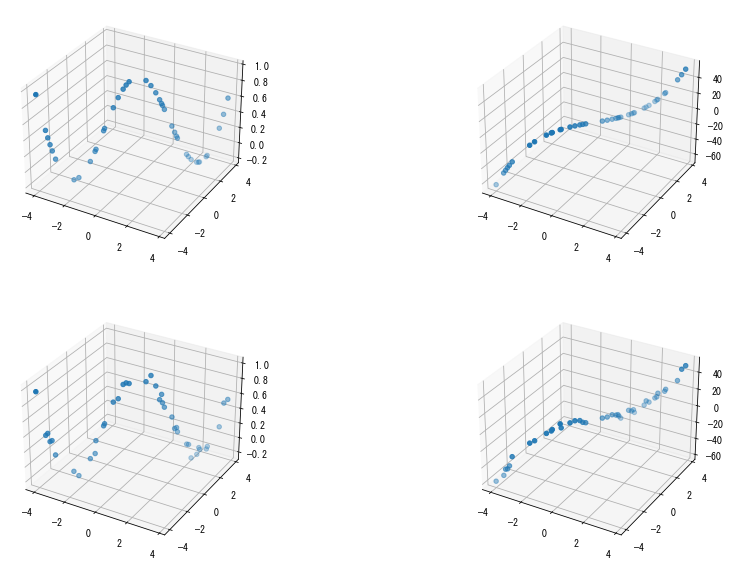

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (15.0, 10.0)
plt.rcParams['font.family'] = "MS Gothic"

fig = plt.figure()

ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax1.scatter(test_x[:,0], test_x[:,1], test_y[:,:1])

ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax2.scatter(test_x[:,0], test_x[:,1], test_y[:,1:])

ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ax3.scatter(test_x[:,0], test_x[:,1], test_pred[:,:1])

ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.scatter(test_x[:,0], test_x[:,1], test_pred[:,1:])